In [3]:
!pip install tensorflow scikit-learn pandas matplotlib

In [44]:
!pip install --upgrade tensorflow keras

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/0f/a5/89a9bdae9f241cad167edb6c890ef2b4c842c5ae81058a2fbfd702dba9bf/tensorflow-2.17.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for keras from https://files.pythonhosted.org/packages/a3/a4/101f0f3c0b057ce150af0e8493ab7fc10b98b066b7bd81ab01e96038a268/keras-3.5.0-py3-none-any.whl.metadata
  Obtaining dependency information for tensorboard<2.18,>=2.17 from https://files.pythonhosted.org/packages/d4/41/dccba8c5f955bc35b6110ff78574e4e5c8226ad62f08e732096c3861309b/tensorboard-2.17.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.2/236.2 MB 9.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 20.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninsta

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
df = pd.read_csv(os.path.join('/Users/yenhuynh/Downloads/jigsaw-toxic-comment-classification-challenge/train.csv'))

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df.iloc[6]['comment_text']

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [5]:
df[df.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
x = df['comment_text']
y = df[df.columns[2:]].values

In [8]:
MAX_WORDS = 200000 #number of words in the vocab

In [9]:
vectorizer = TextVectorization(max_tokens=MAX_WORDS,
                               output_sequence_length=1800,
                               output_mode='int')

In [10]:
vectorizer.adapt(x.values)

In [11]:
vectorized_text = vectorizer(x.values)

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [13]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [14]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [15]:
train_generator = train.as_numpy_iterator()

In [16]:
train_generator.next()

(array([[  718,  1804,     9, ...,     0,     0,     0],
        [ 5574,  2562,   274, ...,     0,     0,     0],
        [   88,     7,    65, ...,     0,     0,     0],
        ...,
        [   40,     1,     0, ...,     0,     0,     0],
        [  451,   126, 27493, ...,     0,     0,     0],
        [  104,     8,    69, ...,     0,     0,     0]]),
 array([[1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding, Input

In [18]:
inputs = Input(shape=(1800,))
x = Embedding(input_dim=MAX_WORDS + 1, output_dim=32)(inputs)
x = Bidirectional(LSTM(32, activation='tanh'))(x)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(6, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,491,686 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 ━━━━━━━━━━━━━━━━━━━━ 3414s 489ms/step - accuracy: 0.9655 - loss: 0.0835 - val_accuracy: 0.9940 - val_loss: 0.0471


In [22]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

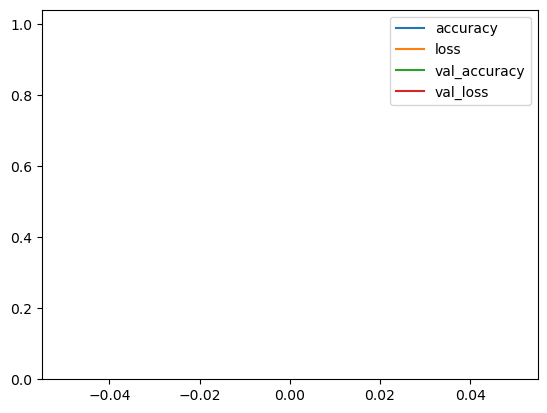

In [23]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [24]:
input_text = vectorizer('You freaking suck! I am going to hurt you')

In [25]:
model.predict(np.expand_dims(input_text,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


array([[0.9823    , 0.15506163, 0.86403906, 0.0537123 , 0.68736285,
        0.133488  ]], dtype=float32)

In [26]:
batch_x, batch_y = test.as_numpy_iterator().next()

In [27]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [28]:
(model.predict(batch_x)>0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [29]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [34]:
for batch in test.as_numpy_iterator():
    x_true, y_true = batch
    yhat = model.predict(x_true)

    # Check the shape before flattening
    print("Before flattening: y_true shape:", y_true.shape, "yhat shape:", yhat.shape)
    
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    # Check the shape after flattening
    print("After flattening: y_true shape:", y_true.shape, "yhat shape:", yhat.shape)

    # Check if the lengths match
    if len(y_true) != len(yhat):
        print("Mismatch in length:", len(y_true), len(yhat))
        continue  # Skip this batch to prevent out of range error

    # If everything seems fine, update the metrics
    try:
        pre.update_state(y_true, yhat)
        re.update_state(y_true, yhat)
        acc.update_state(y_true, yhat)
    except Exception as e:
        print(f"Error during metric update: {e}")
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Before flattening: y_true shape: (16, 6) yhat shape: (16, 6)
After flattening: y_true shape: (96,) yhat shape: (96,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Before flattening: y_true shape: (16, 6) yhat shape: (16, 6)
After flattening: y_true shape: (96,) yhat shape: (96,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Before flattening: y_true shape: (16, 6) yhat shape: (16, 6)
After flattening: y_true shape: (96,) yhat shape: (96,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Before flattening: y_true shape: (16, 6) yhat shape: (16, 6)
After flattening: y_true shape: (96,) yhat shape: (96,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Before flattening: y_true shape: (16, 6) yhat shape: (16, 6)
After flattening: y_true shape: (96,) yhat shape: (96,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Before flattening: y_true shape: (16, 6) yhat shape: (16, 6)
After flattening: y_true shape: (96,) yhat shape: (96,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Before flattening: y_true shape:

2024-08-30 09:55:02.732594: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [35]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8758329749107361, Recall:0.6117021441459656, Accuracy:0.4740889370441437


In [36]:
!pip install gradio jinja2

  Obtaining dependency information for gradio from https://files.pythonhosted.org/packages/86/ef/503bbc4e826cb9b17177da75666a701086fbcb564b16ee4902d400035f3f/gradio-4.42.0-py3-none-any.whl.metadata
  Obtaining dependency information for fastapi from https://files.pythonhosted.org/packages/5c/ae/6570ae1b67007735229f10f2e1174d6e33c056ee9c0c1754d432acbede94/fastapi-0.112.2-py3-none-any.whl.metadata
  Obtaining dependency information for ffmpy from https://files.pythonhosted.org/packages/ff/1e/db99aa669eee301966bc6c997d60a0240f9cecae63f044b2e5a5310e4bf7/ffmpy-0.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for gradio-client==1.3.0 from https://files.pythonhosted.org/packages/de/fe/7e9cb4d0e6aa74268fa31089189e4855882a0f2a36c45d359336946d4ae1/gradio_client-1.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for httpx>=0.24.1 from https://files.pythonhosted.org/packages/56/95/9377bcb415797e44274b51d46e3249eba641711cf3348050f76ee7b15ffc/httpx-0.27.2-py3-none-a

In [41]:
import tensorflow as tf
import gradio as gr

ModuleNotFoundError: No module named 'huggingface_hub._inference'

In [ ]:
model.save('cmt_toxicity.keras')


In [43]:

model = tf.keras.models.load_model('cmt_toxicity.keras', compile=False)

In [44]:

def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [45]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

NameError: name 'gr' is not defined

In [ ]:

interface.launch(share=True)